In [ ]:
!pip install -r requirements.txt

In [5]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

In [28]:
# The Structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

# Failure Analysis Sub-Graph
class FailureAnalysisState(TypedDict):
    docs: List[Logs]
    failures: List[Logs]
    fa_summary: str

def get_failures(state):
    docs = state['docs']
    failures = [doc for doc in docs if 'grade' in docs]
    return {"failures": failures}

def generate_summary(state):
    failures = state['failures']
    fa_summary = "Poor quality retrieval of Chroma documentation"
    return {"fa_summary": fa_summary}

fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, 'get_failures')
fa_builder.add_edge('get_failures', 'generate_summary')
fa_builder.add_edge('generate_summary', END)


# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    docs: List[Logs]
    qs_summary: str
    report: str

def generate_summary(state):
    docs = state['docs']
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary}

def send_to_slack(state):
    qs_summary = state['qs_summary']
    report = "foo bar baz"

    return {"report": report}

def format_report_for_slack(state):
    report = state['report']
    formatted_report = "foo bar"
    
    return {"report": formatted_report}

qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_node("format_report_for_slack", format_report_for_slack)
qs_builder.add_edge(START, 'generate_summary')
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", "format_report_for_slack")
qs_builder.add_edge("format_report_for_slack", END)

In [29]:
# Dummy logs
question_answer = Logs(
    id='1',
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_model import ChatOllama'"
)

question_answer_feedback = Logs(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain)",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieval documents discuss vector store in general, but not Chroma specifically",
)

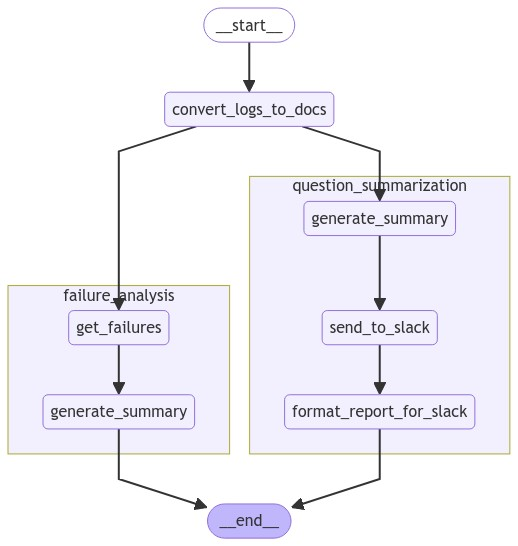

In [41]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[List[Dict], add]
    docs: Annotated[List[Logs], add]
    fa_summary: str
    report: str

def convert_logs_to_docs(state):
    # get logs
    raw_logs = state['raw_logs']
    docs = [question_answer, question_answer_feedback]
    return {"docs": docs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("convert_logs_to_docs", convert_logs_to_docs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "convert_logs_to_docs")
entry_builder.add_edge("convert_logs_to_docs", "failure_analysis")
entry_builder.add_edge("convert_logs_to_docs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
# display(Image(graph.get_graph(xray=10).draw_png()))

In [42]:
raw_logs = [{"foo": "bar"}, {"foo": "baz"}]
graph.invoke({"raw_logs": raw_logs}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'raw_logs': [{'foo': 'bar'}, {'foo': 'baz'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- raw_logs -> [{'foo': 'bar'}, {'foo': 'baz'}]
[1:tasks] Starting step 1 with 1 task:
- convert_logs_to_docs -> {'docs': [],
 'fa_summary': None,
 'raw_logs': [{'foo': 'bar'}, {'foo': 'baz'}],
 'report': None}
[1:writes] Finished step 1 with writes to 1 channel:
- docs -> [{'answer': "To import ChatOllama, use: 'from langchain_community.chat_model "
            "import ChatOllama'",
  'id': '1',
  'question': 'How can I import ChatOllama?'},
 {'answer': 'To use Chroma, define: rag_chain = '
            'create_retrieval_chain(retriever, question_answer_chain)',
  'feedback': 'The retrieval documents discuss vector store in general, but '
              'not Chroma specifically',
  'grade': 0,
  'grader': 'Document Relevance Recall',
  'id': '2',
  'question': 'How can I use Chroma vector store?'}]
[2:tasks] Starting step 2 with 2 tasks

{'raw_logs': [{'foo': 'bar'}, {'foo': 'baz'}],
 'docs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_model import ChatOllama'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain)',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieval documents discuss vector store in general, but not Chroma specifically'},
  {'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_model import ChatOllama'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain)',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieval documents discuss vector 